### Content structure
1. Data preparation  
2. Feature engineering *(in progress)*  
3. Variable selection *(in progress)*  
4. Model building and training *(in progress)*  
5. Testing *(in progress)*

## Data
 
The data consists of candlestick windows, where each candlestick represents one minute. There are 26 candlesticks for each window and the 21st candlestick is a "signal candle" that is either up more than 4% or down more than -4%. The windows were collected for stocks that had satisfied certain thresholds for volume, price, and (high-low)/low. For more details on the data, see the appendix.

## Load data

In [1]:
import os
import pandas as pd
import numpy as np

folder = "windows"
windows_csv_names = os.listdir(folder)
windows = []

for i, f in enumerate(windows_csv_names, start=1):
    w_df = pd.read_csv(os.path.join(folder, f))
    windows.append(w_df)
    
    if i % 5000 == 0:
        print(f"{i} / {len(windows_csv_names)} windows loaded")

print(f"Number of windows: {len(windows)}")

5000 / 23163 windows loaded
10000 / 23163 windows loaded
15000 / 23163 windows loaded
20000 / 23163 windows loaded
Number of windows: 23163


## Clean and check data

In [2]:
# Window parameters
N_CANDLES = 26 # Candles per window
N_CANDLES_BEFORE = 20 # Candles before signal candle
N_CANDLES_AFTER = 5 # Candles after signal candle
I_SIGNAL_CANDLE = N_CANDLES_BEFORE # Index signal candle
I_BUY_CANDLE = I_SIGNAL_CANDLE + 1 # Index buy candle
I_SELL_CANDLE = I_SIGNAL_CANDLE + N_CANDLES_AFTER # Index sell candle
SIGNAL_THR = 0.04 # Threshold for absolute value of (c-o)/o for signal candle

In [3]:
# Example window
windows[0]

,v,vw,o,c,h,l,t,n
0,16771,27.7948,27.755,27.7900,27.840,27.7550,2025-02-21 15:48:00,242
1,8376,27.7565,27.780,27.7650,27.790,27.7100,2025-02-21 15:49:00,124
2,16524,27.7511,27.765,27.7500,27.780,27.7300,2025-02-21 15:50:00,221
3,17292,27.7074,27.745,27.6900,27.750,27.6850,2025-02-21 15:51:00,246
4,19804,27.6796,27.700,27.6740,27.710,27.6500,2025-02-21 15:52:00,246
5,23903,27.6273,27.665,27.5850,27.703,27.5500,2025-02-21 15:53:00,250
6,43268,27.5722,27.575,27.5750,27.603,27.5430,2025-02-21 15:54:00,471
7,30053,27.4358,27.560,27.3300,27.560,27.3300,2025-02-21 15:55:00,328
8,42423,27.2484,27.320,27.2251,27.320,27.1600,2025-02-21 15:56:00,513
9,46713,27.2400,27.235,27.2900,27.300,27.2150,2025-02-21 15:57:00,566


**Note:** Minute difference between rows doesn't have to be 1: candles with no volume are not included.

In [4]:
# Check missing values
has_na = [w_df.isna().any().any() for w_df in windows]
total_with_na = sum(has_na)
print(f"{total_with_na} out of {len(windows)} windows have missing values.")

0 out of 23163 windows have missing values.


In [5]:
# Convert time strings to timestamp
print(f"Type before: {type(windows[0]['t'][0])}")
for w_df in windows:
    w_df['t'] = pd.to_datetime(w_df['t'], errors='raise')
print(f"Type after: {type(windows[0]['t'][0])}")

Type before: <class 'str'>
Type after: <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [6]:
# Check length of windows
lengths = [len(w_df) for w_df in windows]
bad_length_idx = [i for i, L in enumerate(lengths) if L != N_CANDLES]
print(f"{len(bad_length_idx)} windows have incorrect length.")

0 windows have incorrect length.


In [7]:
# Check (close-open)/open for signal candle
signal_perc = [(w_df['c'][I_SIGNAL_CANDLE] - w_df['o'][I_SIGNAL_CANDLE]) / w_df['o'][I_SIGNAL_CANDLE] for w_df in windows]
signal_perc = np.abs(np.array(signal_perc))
bad_signal_idx = [i for i, perc in enumerate(signal_perc) if perc < SIGNAL_THR]

print(f"Min: {np.min(signal_perc):.3f}")
print(f"Max: {np.max(signal_perc):.3f}")


print(f"{len(bad_signal_idx)} windows have bad signal candle.")

Min: 0.040
Max: 0.619
0 windows have bad signal candle.


In [8]:
# Check if dtypes are consistent
ref_dtypes = windows[0].dtypes

inconsistent_idx = []
for i, w_df in enumerate(windows):
    if not w_df.dtypes.equals(ref_dtypes):
        inconsistent_idx.append(i)

print(f"{len(inconsistent_idx)} windows have inconsistent dtypes.")

12332 windows have inconsistent dtypes.


In [9]:
# Check first problem window
print(f"First problem window:\n{windows[inconsistent_idx[0]][:].dtypes}\n")
print(f"Reference window:\n{ref_dtypes}\n")

First problem window:
v            float64
vw           float64
o            float64
c            float64
h            float64
l            float64
t     datetime64[ns]
n              int64
dtype: object

Reference window:
v              int64
vw           float64
o            float64
c            float64
h            float64
l            float64
t     datetime64[ns]
n              int64
dtype: object



In [10]:
# Convert volume to int 
for i in inconsistent_idx:
    windows[i]['v'] = windows[i]['v'].round().astype('int64')

In [11]:
# Check inconsistent windows again
inconsistent_idx = []
for i, w_df in enumerate(windows):
    if not w_df.dtypes.equals(ref_dtypes):
        inconsistent_idx.append(i)

print(f"{len(inconsistent_idx)} windows have inconsistent dtypes.")

0 windows have inconsistent dtypes.


In [12]:
# Check chronological order for each window
not_monotonic_time = np.array([not windows[i]['t'].is_monotonic_increasing for i in range(len(windows))])
print(f"{sum(not_monotonic_time)} windows have incorrect time order")    

0 windows have incorrect time order


## Distribution of some features

In [13]:
# Sort windows (time order probably has meaning for train/test
windows.sort(key=lambda w: w['t'].iloc[0])

In [14]:
# Using first eda_frac to plot features, avoiding test data.
# Assuming >= eda_frac for train set later.

eda_frac = 0.7

n_eda = int(len(windows) * eda_frac)
windows_eda = [w.copy() for w in windows[:n_eda]]

print(f"Using {len(windows_eda)} out of {len(windows)} windows for plots ({eda_frac*100:.0f}%)")

Using 16214 out of 23163 windows for plots (70%)


In [15]:
import matplotlib.pyplot as plt

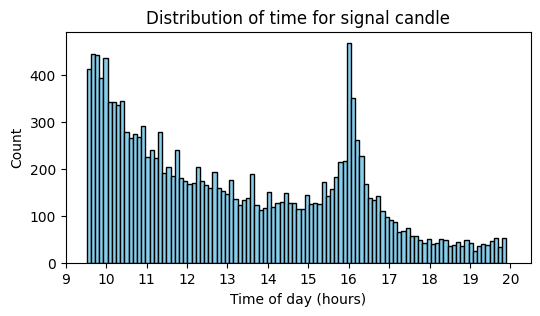

In [16]:
# Distribution of the time of day of signal candles
times_signal_h = []
for w_df in windows_eda:
    time_signal_h = w_df['t'][I_SIGNAL_CANDLE]
    hours = time_signal_h.hour + time_signal_h.minute/60 + time_signal_h.second/3600
    times_signal_h.append(hours)

plt.figure(figsize=(6,3))
plt.hist(times_signal_h, bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Time of day (hours)')
plt.ylabel('Count')
plt.title('Distribution of time for signal candle')
plt.xticks(range(8, 22, 1))
plt.xlim(9, 20.5)
plt.show()

**Note:** More stocks qualify for window collection as the day progresses, which explains the peak at 16:00.

In [17]:
# Distribution of closing price for signal candle
price_signals = np.array([w_df['c'].values[I_SIGNAL_CANDLE] for w_df in windows_eda])

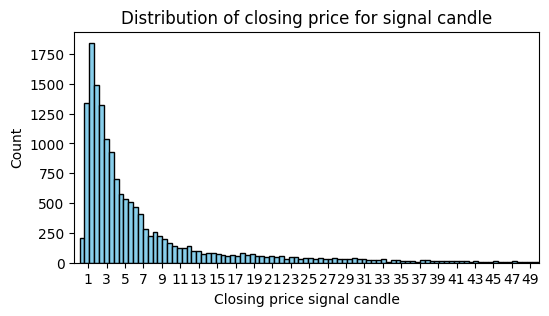

In [18]:
plt.figure(figsize=(6,3))
plt.hist(price_signals, bins=1000, color='skyblue', edgecolor='black')
plt.xlabel('Closing price signal candle')
plt.ylabel('Count')
plt.title(f'Distribution of closing price for signal candle')
plt.xticks(range(1, 50, 2))
plt.xlim(-0.5, 50)
plt.show()

In [19]:
mean_price_signals = np.mean(price_signals)   
median = np.median(price_signals) 
Min = np.min(price_signals)        
Max = np.max(price_signals)  
print(f"Summary of closing price for signal candle:")
print(f"Mean: {mean_price_signals:.2f}, Median: {median:.2f}, Min: {Min:.2f}, Max: {Max:.2f}")

Summary of closing price for signal candle:
Mean: 10.88, Median: 3.73, Min: 0.07, Max: 528.00


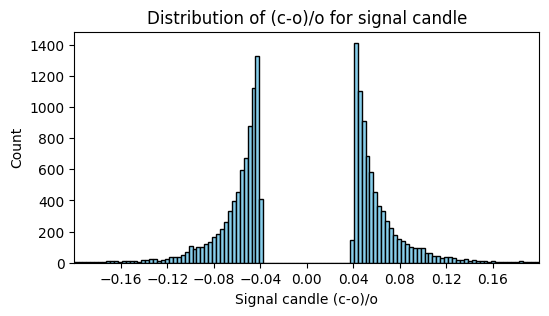

In [20]:
signal_candle_perc = []
for w_df in windows_eda:
    signal_candle_perc.append((w_df['c'][I_SIGNAL_CANDLE] - w_df['o'][I_SIGNAL_CANDLE]) / w_df['o'][I_SIGNAL_CANDLE])
signal_candle_perc = np.array(signal_candle_perc)
plt.figure(figsize=(6,3))
plt.hist(signal_candle_perc, bins=350, color='skyblue', edgecolor='black')
plt.xlabel('Signal candle (c-o)/o')
plt.ylabel('Count')
plt.title(f'Distribution of (c-o)/o for signal candle')
plt.xticks(np.arange(-0.16, 0.16 + 0.01, 0.04))
plt.xlim(-0.2, 0.2)
plt.show()

**Figure:** We can see that the windows are consciously chosen: every signal candle satisfies $|(c-o)/o| \geq 0.04$.

In [21]:
print("Signal candle (c-o)/o summary:")
print(f"Negative candles: min: {np.min(signal_candle_perc):.3f}, max: {np.max(signal_candle_perc[signal_candle_perc < 0]):.3f}")
print(f"Positive candles: min: {np.min(signal_candle_perc[signal_candle_perc > 0]):.3f}, max: {np.max(signal_candle_perc):.3f}")

Signal candle (c-o)/o summary:
Negative candles: min: -0.619, max: -0.040
Positive candles: min: 0.040, max: 0.565


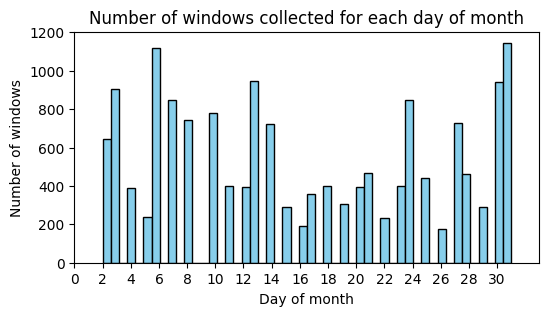

In [22]:
# Distribution of day of month of windows
dayofmonths = []
for w_df in windows_eda:
    dayofmonths.append(w_df['t'].iloc[0].day)
    
plt.figure(figsize=(6,3))
plt.hist(dayofmonths, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Day of month')
plt.ylabel('Number of windows')
plt.title(f'Number of windows collected for each day of month')
plt.xticks(np.arange(0, 31, 2))
plt.xlim(0, 33)
plt.show()

In [23]:
# Baseline return for windows_eda
c_stack = np.stack([w_df['c'] for w_df in windows])
o_stack = np.stack([w_df['o'] for w_df in windows])

returns = (c_stack[:,I_SELL_CANDLE] - o_stack[:, I_BUY_CANDLE]) / o_stack[:, I_BUY_CANDLE] # for train/test sets later
returns_eda = returns[: n_eda]
baseline = np.mean(returns_eda)
print(f"Mean baseline return (using only initial stock selection filter): {baseline:.10f}")

Mean baseline return (using only initial stock selection filter): -0.0000841995


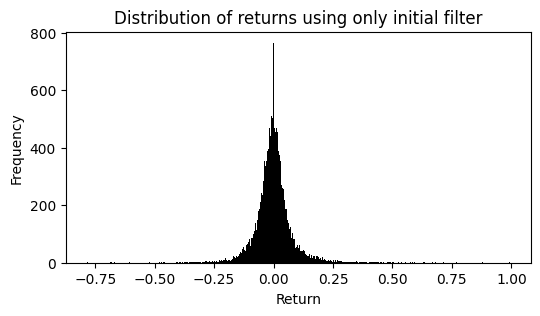

In [24]:
plt.figure(figsize=(6,3))
plt.hist(returns_eda, bins=500, color='black', label="top10")
plt.title("Distribution of returns using only initial filter")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.show()

## Derive time features

In [25]:
print(f"Number of rows up to and including signal candle: {len(windows[0].iloc[:I_BUY_CANDLE])}")
print(f"Number of columns: {len(windows[0].columns)}")
print(f"Number of raw features (nrows*ncols): {len(windows[0].iloc[:I_BUY_CANDLE]) * len(windows[0].dtypes)}")

Number of rows up to and including signal candle: 21
Number of columns: 8
Number of raw features (nrows*ncols): 168


In [26]:
windows[0].dtypes

v              int64
vw           float64
o            float64
c            float64
h            float64
l            float64
t     datetime64[ns]
n              int64
dtype: object

In [27]:
# Derive time features from 't'
for w_df in windows:
    w_df['minute'] = w_df['t'].dt.minute
    w_df['hour'] = w_df['t'].dt.hour
    w_df['dayofweek'] = w_df['t'].dt.dayofweek
    w_df['dayofmonth'] = w_df['t'].dt.day
    w_df['dayofyear'] = w_df['t'].dt.dayofyear
    w_df['month'] = w_df['t'].dt.month

    # Add 'halt': is 1 if > 1min between signal candle and candle after (buy candle)
    w_df['halt'] = (w_df['t'].iloc[I_BUY_CANDLE] - w_df['t'].iloc[I_SIGNAL_CANDLE]) > pd.Timedelta(minutes=1)


print(f"Added time features (using windows[0].iloc[0]) as example):"
      f"\nminute: {windows[0]['minute'].iloc[0]}\nhour: {windows[0]['hour'].iloc[0]}"
      f"\ndayofweek: {windows[0]['dayofweek'].iloc[0]}\ndayofmonth: {windows[0]['dayofmonth'].iloc[0]}"
      f"\ndayofyear: {windows[0]['dayofyear'].iloc[0]}\nmonth: {windows[0]['month'].iloc[0]}"
      f"\nhalt: {windows[0]['halt'].iloc[0]}")

Added time features (using windows[0].iloc[0]) as example):
minute: 11
hour: 9
dayofweek: 0
dayofmonth: 30
dayofyear: 365
month: 12
halt: False


## Flatten windows and create feature dictionary

In [28]:
# Flatten windows
flattened_windows = []
skip_cols = ['t', 'dayofweek', 'dayofmonth', 'dayofyear', 'month', 'halt'] 

for w_df in windows:
    flattened = w_df.iloc[:I_BUY_CANDLE].drop(columns=skip_cols, errors='ignore').values.flatten(order='F')
    
    # features that are constant in each window
    dayofweek = w_df['dayofweek'].iloc[0]
    dayofmonth = w_df['dayofmonth'][0]
    dayofyear = w_df['dayofyear'].iloc[0]
    month = w_df['month'].iloc[0]
    halt = w_df['halt'].iloc[0]
    
    flattened_window = np.array(list(flattened) + [dayofweek, dayofmonth, dayofyear, month, halt])
    flattened_windows.append(flattened_window)

df_flattened_windows = pd.DataFrame(flattened_windows)

n_full_cols = flattened.shape[0] # Number of columns from feature 'families' for which all candles (up to signal) are used, e.g 'c', 'o', 'v', 'vw'

print(df_flattened_windows.shape)
print(f"Features per window: {df_flattened_windows.shape[1]}")

(23163, 194)
Features per window: 194


In [29]:
# Create feature dictionary for flattened windows

headers_full_cols = ['v', 'vw', 'o', 'c', 'h', 'l', 'n', 'minute', 'hour']
dict_raw_features = {}

# First column
dict_raw_features[0] = 'rtn'

# Columns with whose all rows are used
for i in range(1, n_full_cols + 1):  
    if (i - 1) % (N_CANDLES_BEFORE + 1) == 0:
        # change header
        header = headers_full_cols[i // (N_CANDLES_BEFORE + 1)]
    candle = (i - 1) % (N_CANDLES_BEFORE + 1)
    dict_raw_features[i] = f"{header}_candle_{candle + 1}"

# Columns with only one value
for i in range(len(skip_cols) - 1): # 'rtn' already first col, 't' is not numeric
    dict_raw_features[i + n_full_cols + 1] = f"{skip_cols[i+1]}" # +1 to skip 't'

print(f'len(dict_raw_features): {len(dict_raw_features)}')

len(dict_raw_features): 195


## Screening with correlations and decision trees

In [30]:
# Use first n_eda for screening
df_flattened_windows_eda = df_flattened_windows.iloc[:n_eda].copy()

# Add return to first col
df_flattened_windows_eda.insert(0, 'rtn' , returns_eda)
df_flattened_windows_eda.columns = range(len(df_flattened_windows_eda.columns))

df_flattened_windows_eda.shape

(16214, 195)

In [31]:
# Pearson and Spearman correlations for all columns vs first column (target)
pearsons = df_flattened_windows_eda.corr(method='pearson').iloc[0]
spearmans = df_flattened_windows_eda.corr(method='spearman').iloc[0]

pearsons_abs = pearsons.abs()
spearmans_abs = spearmans.abs()

In [32]:
# Print top correlations

# Print settings
L_1 = 35 # left adjust first print
L_2 = 10 # left adjust second print

top_n_corr = 20

top_n_pear_abs = pearsons_abs.sort_values(ascending=False).head(top_n_corr)
top_n_pear = pearsons[top_n_pear_abs.index]

top_n_spear_abs = spearmans_abs.sort_values(ascending=False).head(top_n_corr)
top_n_spear = spearmans[top_n_spear_abs.index]

print("".ljust(4), f"Top {top_n_corr} Pearson:".ljust(L_1+15), f"Top {top_n_corr} Spearman:".ljust(12))

print("".ljust(L_1+5), "Pearson".ljust(L_1+15), "Spearman")
for i in range(top_n_corr):
    print(f"{i+1}".ljust(4), f"Column {top_n_pear.index[i]} ({dict_raw_features[top_n_pear.index[i]]})".ljust(L_1),\
          f"{top_n_pear.iloc[i]:.4f}".ljust(14),\
          f"Column {top_n_spear.index[i]} ({dict_raw_features[top_n_spear.index[i]]})".ljust(L_1),\
          f"{top_n_spear.iloc[i]:.4f}")

     Top 20 Pearson:                                    Top 20 Spearman:
                                         Pearson                                            Spearman
1    Column 0 (rtn)                      1.0000         Column 0 (rtn)                      1.0000
2    Column 133 (n_candle_7)             -0.0185        Column 145 (n_candle_19)            -0.0615
3    Column 145 (n_candle_19)            -0.0181        Column 146 (n_candle_20)            -0.0601
4    Column 131 (n_candle_5)             -0.0174        Column 144 (n_candle_18)            -0.0592
5    Column 186 (hour_candle_18)         0.0151         Column 143 (n_candle_17)            -0.0543
6    Column 187 (hour_candle_19)         0.0149         Column 19 (v_candle_19)             -0.0537
7    Column 184 (hour_candle_16)         0.0148         Column 18 (v_candle_18)             -0.0529
8    Column 185 (hour_candle_17)         0.0148         Column 20 (v_candle_20)             -0.0519
9    Column 5 (v_candle_5) 

n, hour, v possibly interesting

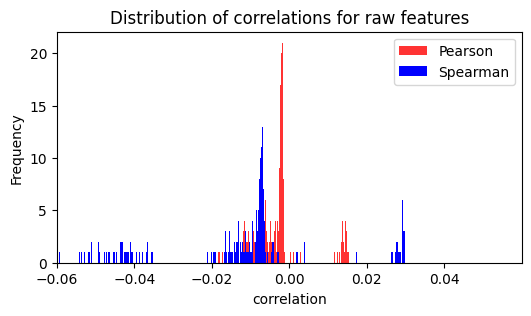

In [33]:
# Histogram of correlations
plt.figure(figsize=(6,3))
plt.hist(pearsons, bins=4000, color='red', alpha=0.8, label="Pearson")
plt.hist(spearmans, bins=4000, color='blue', label="Spearman")
plt.xlabel('correlation')
plt.ylabel('Frequency')
plt.title(f'Distribution of correlations for raw features')
plt.xticks(np.arange(-0.06, 0.06, 0.02))
plt.xlim(-0.06, 0.06)
plt.legend()
plt.show()

In [34]:
# Decision tree screening

from sklearn.tree import DecisionTreeRegressor

X = df_flattened_windows_eda.iloc[:, 1:]  # all features
y = df_flattened_windows_eda.iloc[:, 0]   # target

results_d1 = {}
results_d2 = {}

# custom depth
d = 10
results_d = {}

save_thr_d1 = []
for col in X.columns:
    tree_d1 = DecisionTreeRegressor(max_depth=1)
    tree_d1.fit(X[[col]], y)  # X[[col]] keeps it as 2D
    score_d1 = tree_d1.score(X[[col]], y)  # R^2 score
    results_d1[col] = score_d1
    save_thr_d1.append((tree_d1.tree_.threshold, tree_d1.tree_.value))
    
    tree_d2 = DecisionTreeRegressor(max_depth=2)
    tree_d2.fit(X[[col]], y)  # note: X[[col]] keeps it as 2D
    score_d2 = tree_d2.score(X[[col]], y)  # R^2 score
    results_d2[col] = score_d2   

    tree_d = DecisionTreeRegressor(max_depth=d)
    tree_d.fit(X[[col]], y)  # note: X[[col]] keeps it as 2D
    score_d = tree_d.score(X[[col]], y)  # R^2 score
    results_d[col] = score_d

In [35]:
n_top = 20

d1_sorted = sorted(results_d1.items(), key=lambda x: x[1], reverse=True)
top_d1 = d1_sorted[:n_top]

d2_sorted = sorted(results_d2.items(), key=lambda x: x[1], reverse=True)
top_d2 = d2_sorted[:n_top]

d_sorted = sorted(results_d.items(), key=lambda x: x[1], reverse=True)
top_d = d_sorted[:n_top]

print(f"Top {n_top} R^2 scores from depth 1, depth 2 and depth {d} decision trees:\n")
print("".ljust(9), "Depth 1".ljust(25), "Depth 2".ljust(25), f"Depth {d}\n")
for i in range(n_top):
    print(f"{i+1}".ljust(4),
          f"{dict_raw_features[top_d1[i][0]]}".ljust(15), f"{top_d1[i][1]:.3f}".ljust(9),\
          f"{dict_raw_features[top_d2[i][0]]}".ljust(15), f"{top_d2[i][1]:.3f}".ljust(9),\
          f"{dict_raw_features[top_d[i][0]]}".ljust(15), f"{top_d[i][1]:.3f}")

Top 20 R^2 scores from depth 1, depth 2 and depth 10 decision trees:

          Depth 1                   Depth 2                   Depth 10

1    l_candle_13     0.017     c_candle_13     0.018     vw_candle_14    0.083
2    c_candle_13     0.016     l_candle_13     0.018     l_candle_1      0.079
3    vw_candle_13    0.015     o_candle_13     0.017     l_candle_2      0.078
4    o_candle_13     0.015     c_candle_12     0.016     o_candle_14     0.077
5    c_candle_12     0.015     vw_candle_13    0.016     vw_candle_12    0.076
6    l_candle_14     0.014     l_candle_18     0.016     vw_candle_13    0.074
7    o_candle_14     0.014     c_candle_14     0.016     c_candle_14     0.073
8    vw_candle_14    0.014     o_candle_14     0.016     c_candle_12     0.070
9    c_candle_14     0.013     l_candle_14     0.016     v_candle_19     0.070
10   l_candle_18     0.013     vw_candle_14    0.016     vw_candle_17    0.069
11   h_candle_14     0.013     l_candle_12     0.015     vw_candle_1

vw, o, h c, l possibly interesting

## Engineer features

All engineered features are categorized with a "feature family name" that starts with "E_". Each family consists of a number of actual features. This number starts with "n_".

In [36]:
# Function to check engineered features
def check_nans_infs(array, shape=True):
    inf_mask = np.isinf(array)
    nans_mask = np.isnan(array)
    print(f"infs: {np.sum(inf_mask)}")
    print(f"nans: {np.sum(nans_mask)}")
    if shape:
        print(f"Shape: {array.shape}")

In [37]:
def slope_parts(stack, n_parts, window_len=I_SIGNAL_CANDLE):
    """
    stack has shape (len(windows), m), where m >= I_SIGNAL_CANDLE.
    Divide axis 1 into n_parts, return slope for each part and each row.

    Slices each part from the end, so the last candles (closest to the signal candle) are prioritized.
    If I_SIGNAL_CANDLE % n_parts != 0, older candles at the beginning may be ignored.
    """
    stack = stack[:, :window_len]
    n_candles = window_len // n_parts
    x = np.arange(n_candles)
    x_mean = x.mean()
    x_ssd = np.sum((x - x_mean)**2) # sum of squared deviations
    slopes = np.zeros((len(windows_e), n_parts))
    for i in range(n_parts):
        part = stack[:, window_len - (i+1) * n_candles:window_len - i * n_candles]
        slopes[:, i] = np.sum((part - part.mean(axis=1).reshape(-1, 1)) * (x - x_mean), axis=1) / x_ssd
    return slopes

In [38]:
def normalize_stack(stack, window_len, eps=1e-8):
    """ 
    Normalize stack using formula (x - x_min) / (x_max - x_min).
    input shape: (num_windows, m), where m >= window_len.
    output shape: (num_windows, window_len).
    """
    stack_min = np.min(stack[:, :window_len], axis=1).reshape(-1, 1)
    stack_max = np.max(stack[:, :window_len], axis=1).reshape(-1, 1)
    norm = (stack[:, :window_len] - stack_min) / np.where(stack_max - stack_min == 0, eps, stack_max - stack_min)
    return norm

In [39]:
def crtn_slopes(price_setting, window_len, log=True):
    """
    input shape: (num_windows, m), where m >= window_len.
    Output shapes:
    crtn: (num_windows, window_len - 1),
    crtn_slope_1: (num_windows, 1)
    crtn_slope_2: (num_windows, 2)
    crtn_slope_4: (num_windows, 4)

    Given price_setting:
    crtn: cumulative returns from candle 2 up to candle window_len.
    crtn_slope_1: Slope for full window
    crtn_slope_2: Slopes for first and second halves
    crtn_slope_4: Slopes for all 1/4'th parts of the window    
    """
    price_stack = np.stack([w_df[price_setting].to_numpy() for w_df in windows_e])
    price_0 = price_stack[:, 0][:, None]
    crtn = np.log(price_stack[:, 1:window_len] / price_0)
    if not log:
        crtn = (price_stack[:, 1:window_len] - price_0) / price_0
    crtn_slope_1 = slope_parts(crtn, window_len=window_len-1, n_parts=1)
    crtn_slope_2 = slope_parts(crtn, window_len=window_len-1, n_parts=2)
    crtn_slope_4 = slope_parts(crtn, window_len=window_len-1, n_parts=4)
    return crtn, crtn_slope_1, crtn_slope_2, crtn_slope_4

In [40]:
# Make sure to only use candles 1, ..., signal_candle for feature engineering
windows_e = [w_df.iloc[:I_SIGNAL_CANDLE + 1].copy() for w_df in windows]

In [41]:
# cumulative return from candle 2 to signal candle, price_setting = 'o'
# name: E_crtn_o
n_crtn_o = 19

# Cumulative rtn slope for full window, not incl. signal
# name: E_crtn_o_slope_1
n_crtn_o_slope_1 = 1

# Cumulative rtn slope 2 parts, not incl. signal
# name: E_crtn_o_slope_2
n_crtn_o_slope_2 = 2

# Cumulative rtn slope 4 parts, not incl. signal
# name: E_crtn_o_slope_4
n_crtn_o_slope_4 = 4

crtn_o, crtn_o_slope_1, crtn_o_slope_2, crtn_o_slope_4 = crtn_slopes(price_setting='o', window_len=I_SIGNAL_CANDLE)

check_nans_infs(crtn_o)
check_nans_infs(crtn_o_slope_1)
check_nans_infs(crtn_o_slope_2)
check_nans_infs(crtn_o_slope_4)

infs: 0
nans: 0
Shape: (23163, 19)
infs: 0
nans: 0
Shape: (23163, 1)
infs: 0
nans: 0
Shape: (23163, 2)
infs: 0
nans: 0
Shape: (23163, 4)


In [42]:
# cumulative return from candle 2 to signal candle, price_setting = 'c'
# name: E_crtn_c
n_crtn_c = 19

# Cumulative rtn slope for full window, not incl. signal
# name: E_crtn_c_slope_1
n_crtn_c_slope_1 = 1

# Cumulative rtn slope 2 parts, not incl. signal
# name: E_crtn_c_slope_2
n_crtn_c_slope_2 = 2

# Cumulative rtn slope 4 parts, not incl. signal
# name: E_crtn_c_slope_4
n_crtn_c_slope_4 = 4

crtn_c, crtn_c_slope_1, crtn_c_slope_2, crtn_c_slope_4 = crtn_slopes(price_setting='c', window_len=I_SIGNAL_CANDLE)

check_nans_infs(crtn_c)
check_nans_infs(crtn_c_slope_1)
check_nans_infs(crtn_c_slope_2)
check_nans_infs(crtn_c_slope_4)

infs: 0
nans: 0
Shape: (23163, 19)
infs: 0
nans: 0
Shape: (23163, 1)
infs: 0
nans: 0
Shape: (23163, 2)
infs: 0
nans: 0
Shape: (23163, 4)


In [43]:
# cumulative return from candle 2 to signal candle, price_setting = 'h'
# name: E_crtn_h
n_crtn_h = 19

# Cumulative rtn slope for full window, not incl. signal
# name: E_crtn_h_slope_1
n_crtn_h_slope_1 = 1

# Cumulative rtn slope 2 parts, not incl. signal
# name: E_crtn_h_slope_2
n_crtn_h_slope_2 = 2

# Cumulative rtn slope 4 parts, not incl. signal
# name: E_crtn_h_slope_4
n_crtn_h_slope_4 = 4

crtn_h, crtn_h_slope_1, crtn_h_slope_2, crtn_h_slope_4 = crtn_slopes(price_setting='h', window_len=I_SIGNAL_CANDLE)

check_nans_infs(crtn_h)
check_nans_infs(crtn_h_slope_1)
check_nans_infs(crtn_h_slope_2)
check_nans_infs(crtn_h_slope_4)

infs: 0
nans: 0
Shape: (23163, 19)
infs: 0
nans: 0
Shape: (23163, 1)
infs: 0
nans: 0
Shape: (23163, 2)
infs: 0
nans: 0
Shape: (23163, 4)


In [44]:
# cumulative return from candle 2 to signal candle, price_setting = 'l'
# name: E_crtn_l
n_crtn_l = 19

# Cumulative rtn slope for full window, not incl. signal
# name: E_crtn_l_slope_1
n_crtn_l_slope_1 = 1

# Cumulative rtn slope 2 parts, not incl. signal
# name: E_crtn_h_slope_2
n_crtn_l_slope_2 = 2

# Cumulative rtn slope 4 parts, not incl. signal
# name: E_crtn_h_slope_4
n_crtn_l_slope_4 = 4

crtn_l, crtn_l_slope_1, crtn_l_slope_2, crtn_l_slope_4 = crtn_slopes(price_setting='l', window_len=I_SIGNAL_CANDLE)

check_nans_infs(crtn_l)
check_nans_infs(crtn_l_slope_1)
check_nans_infs(crtn_l_slope_2)
check_nans_infs(crtn_l_slope_4)

infs: 0
nans: 0
Shape: (23163, 19)
infs: 0
nans: 0
Shape: (23163, 1)
infs: 0
nans: 0
Shape: (23163, 2)
infs: 0
nans: 0
Shape: (23163, 4)


In [45]:
# close to close log return for candles 2, ... ,signal_candle (first candle has no previous)
# name: E_c2c_log_rtn   
n_c2c_log_rtn = 20 # 20 candles

closes = np.stack([w_df['c'].to_numpy() for w_df in windows_e])
c2c_log_rtn = np.log(closes[:, 1:I_BUY_CANDLE] / closes[:, :I_BUY_CANDLE-1])

check_nans_infs(c2c_log_rtn)

infs: 0
nans: 0
Shape: (23163, 20)


In [46]:
# Rel. dist to vwap: (price - vwap) / vwap for each candle
# name: E_vw_dist
n_vw_dist = 21

price_setting = 'h'

vw_stack = np.stack([w_df['vw'].to_numpy() for w_df in windows_e])
price_stack = np.stack([w_df[price_setting].to_numpy() for w_df in windows_e])
vw_dist = (price_stack[:, :I_BUY_CANDLE] - vw_stack[:, :I_BUY_CANDLE]) / vw_stack[:, :I_BUY_CANDLE]

check_nans_infs(vw_dist)

infs: 0
nans: 0
Shape: (23163, 21)


In [47]:
# Close signal candle relative to high, low:
# (close_signal_candle - low_prevs) / (high_prevs - low_prevs)
# name: E_signal_high_low
n_signal_high_low = 1

n_prev = 20

lows = np.stack([w_df['l'].to_numpy() for w_df in windows_e])
lows_prev = np.min(lows[:, I_SIGNAL_CANDLE - n_prev:I_SIGNAL_CANDLE], axis=1)
highs = np.stack([w_df['h'].to_numpy() for w_df in windows_e])
highs_prev = np.max(highs[:, I_SIGNAL_CANDLE - n_prev:I_SIGNAL_CANDLE], axis=1)
signal_close = np.stack([w_df['c'].to_numpy()[I_SIGNAL_CANDLE] for w_df in windows_e])

signal_high_low = (signal_close - lows_prev) / (highs_prev - lows_prev)

signal_high_low = signal_high_low.reshape(-1, 1)
check_nans_infs(signal_high_low)

infs: 0
nans: 0
Shape: (23163, 1)


In [48]:
# Normalize volume: vol_norm = (v - v_min) / (v_max - v_min)
# name: E_vol_norm
n_vol_norm = 21

vol_stack = np.stack([w_df['v'].to_numpy() for w_df in windows_e])
vol_norm = normalize_stack(vol_stack, I_BUY_CANDLE)

check_nans_infs(vol_norm)

infs: 0
nans: 0
Shape: (23163, 21)


In [49]:
# Normalized volume slope full window, not incl. signal
# name: E_norm_vol_slope_1
n_norm_vol_slope_1 = 1

norm_vol_slope_1 = slope_parts(vol_norm, n_parts=1)

check_nans_infs(norm_vol_slope_1)

infs: 0
nans: 0
Shape: (23163, 1)


In [50]:
# Normalized volume slope 2 parts
# name: E_norm_vol_slope_2
n_norm_vol_slope_2 = 2

norm_vol_slope_2 = slope_parts(vol_norm, n_parts=2)

check_nans_infs(norm_vol_slope_2)

infs: 0
nans: 0
Shape: (23163, 2)


In [51]:
# Normalized volume slope 4 parts
# name: E_norm_vol_slope_4
n_norm_vol_slope_4 = 4

norm_vol_slope_4 = slope_parts(vol_norm, n_parts=4)

check_nans_infs(norm_vol_slope_4)

infs: 0
nans: 0
Shape: (23163, 4)


In [52]:
# Normalize 'n': n_norm = (n - n_min) / (n_max - n_min)
# name: E_n_norm
n_n_norm = 21

n_stack = np.stack([w_df['n'].to_numpy() for w_df in windows_e])
n_norm = normalize_stack(n_stack, I_BUY_CANDLE)

check_nans_infs(n_norm)

infs: 0
nans: 0
Shape: (23163, 21)


In [53]:
# Normalized n slope 1 part
# name: E_norm_n_slope_1
n_norm_n_slope_1 = 1

norm_n_slope_1 = slope_parts(n_norm, n_parts=1)

check_nans_infs(norm_n_slope_1)

infs: 0
nans: 0
Shape: (23163, 1)


In [54]:
# Normalized n slope 2 parts
# name: E_norm_n_slope_2
n_norm_n_slope_2 = 2

norm_n_slope_2 = slope_parts(n_norm, n_parts=2)

check_nans_infs(norm_n_slope_2)

infs: 0
nans: 0
Shape: (23163, 2)


In [55]:
# Normalized n slope 4 parts
# name: E_norm_n_slope_4
n_norm_n_slope_4 = 4

norm_n_slope_4 = slope_parts(n_norm, n_parts=4)

check_nans_infs(norm_n_slope_4)

infs: 0
nans: 0
Shape: (23163, 4)


In [56]:
# vol_signal / vol_max
# name: E_vol_sig_max
n_vol_sig_max = 1

eps = 1e-8
vol_stack = np.stack([w_df['v'].to_numpy() for w_df in windows_e])
volmax = np.max(vol_stack[:, :I_SIGNAL_CANDLE], axis=1)
vol_sig_max = vol_stack[:, I_SIGNAL_CANDLE] / np.where(volmax == 0, eps, volmax)
vol_sig_max = np.log(np.where(vol_sig_max <= 0, eps, vol_sig_max))

vol_sig_max = vol_sig_max.reshape(-1, 1)
check_nans_infs(vol_sig_max)

infs: 0
nans: 0
Shape: (23163, 1)


In [57]:
# vol_signal_candle / vol_n_prev_candles
# name: E_sig_rel_vol
n_sig_rel_vol = 1

n_prev = 10

v_matrix = np.stack([w_df['v'].to_numpy() for w_df in windows_e])
vol_n_prev = np.sum(v_matrix[:, I_SIGNAL_CANDLE - n_prev:I_SIGNAL_CANDLE], axis=1)
vol_signal = v_matrix[:, I_SIGNAL_CANDLE]
sig_rel_vol = vol_signal / np.where(vol_n_prev == 0, 1e-8, vol_n_prev) # volume can be 0 for some candles

sig_rel_vol = sig_rel_vol.reshape(-1, 1)
check_nans_infs(sig_rel_vol)

infs: 0
nans: 0
Shape: (23163, 1)


In [58]:
# high--low convergence and high slope and low slope   (based on normalized highs and lows)
# names:
# E_norm_high_slope
# E_norm_low_slope
# E_highlow_gap_end
n_norm_high_slope = 1
n_norm_low_slope = 1
n_highlow_gap_end = 1

lows = np.stack([w_df['l'].to_numpy() for w_df in windows_e])[:, :I_SIGNAL_CANDLE]
highs = np.stack([w_df['h'].to_numpy() for w_df in windows_e])[:, :I_SIGNAL_CANDLE]

l_min = lows.min(axis=1).reshape(-1, 1)   # use the lowest low
h_max = highs.max(axis=1).reshape(-1, 1)  # use the highest high

highs_norm = (highs - l_min) / np.where(h_max - l_min == 0, 1e-8, h_max - l_min)
lows_norm  = (lows  - l_min) / np.where(h_max - l_min == 0, 1e-8, h_max - l_min)

norm_high_slope = np.zeros((len(windows_e), 1))
norm_low_slope = np.zeros((len(windows_e), 1))
highlow_gap_end = np.zeros((len(windows_e), 1))

x = np.arange(I_SIGNAL_CANDLE)
for i in range(len(windows_e)):
    highs_linreg = np.polyfit(x, highs_norm[i, :], 1)
    lows_linreg = np.polyfit(x, lows_norm[i, :], 1)
    norm_high_slope[i, 0] = highs_linreg[0]
    norm_low_slope[i, 0] = lows_linreg[0]
    highlow_gap_end[i, 0] = highs_linreg[1] + highs_linreg[0] * x[-1] - (lows_linreg[1] + lows_linreg[0] * x[-1])

check_nans_infs(norm_high_slope)
check_nans_infs(norm_low_slope)
check_nans_infs(highlow_gap_end)

infs: 0
nans: 0
Shape: (23163, 1)
infs: 0
nans: 0
Shape: (23163, 1)
infs: 0
nans: 0
Shape: (23163, 1)


In [59]:
# Cyclical encoding of minute, dayofweek, dayofmonth
# names:
# E_minute_cos
# E_minute_sin
# E_dayofweek_cos
# E_dayofweek_sin
# E_dayofmonth_cos
# E_dayofmonth_sin

n_minute_cos = 21
n_minute_sin = 21
n_dayofweek_cos = 1
n_dayofweek_sin = 1
n_dayofmonth_cos = 1
n_dayofmonth_sin = 1

minute = np.stack([w_df['minute'].to_numpy() for w_df in windows_e])[:, :I_BUY_CANDLE]
dayofweek = np.stack([w_df['dayofweek'].to_numpy() for w_df in windows_e])[:, I_SIGNAL_CANDLE]
dayofmonth = np.stack([w_df['dayofmonth'].to_numpy() for w_df in windows_e])[:, I_SIGNAL_CANDLE]

minute_cos = np.cos(2 * np.pi * minute / 60)
minute_sin = np.sin(2 * np.pi * minute / 60)

dayofweek_cos = np.cos(2 * np.pi * dayofweek / 7).reshape(-1, 1)
dayofweek_sin = np.sin(2 * np.pi * dayofweek / 7).reshape(-1, 1)

dayofmonth_cos = np.cos(2 * np.pi * dayofmonth / 30).reshape(-1, 1)
dayofmonth_sin = np.sin(2 * np.pi * dayofmonth / 30).reshape(-1, 1)

check_nans_infs(minute_cos)
check_nans_infs(minute_sin)
check_nans_infs(dayofweek_cos)
check_nans_infs(dayofweek_sin)
check_nans_infs(dayofmonth_cos)
check_nans_infs(dayofmonth_sin)

infs: 0
nans: 0
Shape: (23163, 21)
infs: 0
nans: 0
Shape: (23163, 21)
infs: 0
nans: 0
Shape: (23163, 1)
infs: 0
nans: 0
Shape: (23163, 1)
infs: 0
nans: 0
Shape: (23163, 1)
infs: 0
nans: 0
Shape: (23163, 1)


In [60]:
# Normalized signal hour    (hour - hour_min) / (hour_max - hour_min)
# name: E_signal_hour_norm
n_signal_hour_norm = 1

hour = np.stack([w_df['hour'] for w_df in windows_e])[:, I_SIGNAL_CANDLE]
hour_max = np.max(hour)
hour_min = np.min(hour)

signal_hour_norm = (hour - hour_min) / (hour_max - hour_min)
signal_hour_norm = signal_hour_norm.reshape(-1, 1)

check_nans_infs(signal_hour_norm)

infs: 0
nans: 0
Shape: (23163, 1)


In [61]:
# Mean volume candles before signal
# name: E_vol_mean
n_vol_mean = 1

vol_stack = np.stack([w_df['v'] for w_df in windows_e])
vol_mean = np.mean(vol_stack[:, :I_SIGNAL_CANDLE], axis=1)
vol_mean = vol_mean.reshape(-1,1)

# vol_sig / mean_vol
# name: E_vol_sig_vs_mean
n_vol_sig_vs_mean = 1
vol_sig_vs_mean = vol_stack[:, I_SIGNAL_CANDLE] / vol_mean[:, 0]
vol_sig_vs_mean = vol_sig_vs_mean.reshape(-1, 1)

check_nans_infs(vol_mean)
check_nans_infs(vol_sig_vs_mean)

infs: 0
nans: 0
Shape: (23163, 1)
infs: 0
nans: 0
Shape: (23163, 1)


In [62]:
# Mean price candles before signal
# name: E_price_mean
n_price_mean = 1

price_setting = 'c'

c_stack = np.stack([w_df[price_setting] for w_df in windows_e])
price_mean = np.mean(c_stack[:, :I_SIGNAL_CANDLE], axis=1)
price_mean = price_mean.reshape(-1, 1)

# c_signal / mean_price_c
# name: E_price_sig_vs_mean
n_price_sig_vs_mean = 1
price_sig_vs_mean = c_stack[:, I_SIGNAL_CANDLE] / price_mean[:, 0]
price_sig_vs_mean = price_sig_vs_mean.reshape(-1, 1)

check_nans_infs(price_mean)
check_nans_infs(price_sig_vs_mean)

infs: 0
nans: 0
Shape: (23163, 1)
infs: 0
nans: 0
Shape: (23163, 1)


In [63]:
# Mean numtrades candles before signal
# name: E_numtrades_mean
n_numtrades_mean = 1
numtrades_stack = np.stack([w_df['n'] for w_df in windows_e])
numtrades_mean = np.mean(numtrades_stack[:, :I_SIGNAL_CANDLE], axis=1)
numtrades_mean = numtrades_mean.reshape(-1, 1)

# numtrades_signal / mean_numtrades
# name: E_numtrades_sig_vs_mean
n_numtrades_sig_vs_mean = 1
numtrades_sig_vs_mean = numtrades_stack[:, I_SIGNAL_CANDLE] / numtrades_mean[:, 0]
numtrades_sig_vs_mean = numtrades_sig_vs_mean.reshape(-1, 1)

check_nans_infs(numtrades_mean)
check_nans_infs(numtrades_sig_vs_mean)

infs: 0
nans: 0
Shape: (23163, 1)
infs: 0
nans: 0
Shape: (23163, 1)


In [64]:
# Mean dollar amount candles before signal
# name: E_dollar_amount_mean
n_dollar_amount_mean = 1

price_setting = 'o'

v_stack = np.stack([w_df['v'] for w_df in windows_e])
price_stack = np.stack([w_df[price_setting] for w_df in windows_e])

tot_dollar_amount = np.sum(v_stack[:, :I_SIGNAL_CANDLE] * price_stack[:, :I_SIGNAL_CANDLE], axis=1)
dollar_amount_mean = tot_dollar_amount / I_SIGNAL_CANDLE
dollar_amount_mean = dollar_amount_mean.reshape(-1, 1)

# dollar_amount_signal / mean
# name: E_dollar_amount_sig_vs_mean
n_dollar_amount_sig_vs_mean = 1

dollar_sig = v_stack[:, I_SIGNAL_CANDLE] * price_stack[:, I_SIGNAL_CANDLE]
dollar_amount_sig_vs_mean = dollar_sig / dollar_amount_mean[:, 0]
dollar_amount_sig_vs_mean = dollar_amount_sig_vs_mean.reshape(-1, 1)

check_nans_infs(dollar_amount_mean)
check_nans_infs(dollar_amount_sig_vs_mean)

infs: 0
nans: 0
Shape: (23163, 1)
infs: 0
nans: 0
Shape: (23163, 1)


In [65]:
# close / open
# name: E_close_vs_open
n_close_vs_open = 21

c_stack = np.stack([w_df['c'] for w_df in windows_e])[:, :I_BUY_CANDLE]
o_stack = np.stack([w_df['o'] for w_df in windows_e])[:, :I_BUY_CANDLE]
close_vs_open = np.log(c_stack / o_stack)

check_nans_infs(close_vs_open)

infs: 0
nans: 0
Shape: (23163, 21)


In [66]:
# high / low
# name: E_high_vs_low
n_high_vs_low = 21

h_stack = np.stack([w_df['h'] for w_df in windows_e])[:, :I_BUY_CANDLE]
l_stack = np.stack([w_df['l'] for w_df in windows_e])[:, :I_BUY_CANDLE]
high_vs_open = np.log(h_stack / l_stack)

check_nans_infs(high_vs_open)

infs: 0
nans: 0
Shape: (23163, 21)


In [67]:
# Momentum indicators: RSI, MACD, cumulative returns   ?

# Engineered features screening

In [68]:
# Dictionary for feature families

dict_feature_families = {
    'E_crtn_o': n_crtn_o,
    'E_crtn_o_slope_1': n_crtn_o_slope_1,
    'E_crtn_o_slope_2': n_crtn_o_slope_2,
    'E_crtn_o_slope_4': n_crtn_o_slope_4,
    'E_crtn_c': n_crtn_c,
    'E_crtn_c_slope_1': n_crtn_c_slope_1,
    'E_crtn_c_slope_2': n_crtn_c_slope_2,
    'E_crtn_c_slope_4': n_crtn_c_slope_4,
    'E_crtn_h': n_crtn_h,
    'E_crtn_h_slope_1': n_crtn_h_slope_1,
    'E_crtn_h_slope_2': n_crtn_h_slope_2,
    'E_crtn_h_slope_4': n_crtn_h_slope_4,
    'E_crtn_l': n_crtn_l,
    'E_crtn_l_slope_1': n_crtn_l_slope_1,
    'E_crtn_l_slope_2': n_crtn_l_slope_2,
    'E_crtn_l_slope_4': n_crtn_l_slope_4,
    'E_c2c_log_rtn': n_c2c_log_rtn,
    'E_vw_dist': n_vw_dist,
    'E_signal_high_low': n_signal_high_low,
    'E_vol_norm': n_vol_norm,
    'E_norm_vol_slope_1': n_norm_vol_slope_1,
    'E_norm_vol_slope_2': n_norm_vol_slope_2,
    'E_norm_vol_slope_4': n_norm_vol_slope_4,
    'E_n_norm': n_n_norm,     
    'E_norm_n_slope_1': n_norm_n_slope_1,
    'E_norm_n_slope_2': n_norm_n_slope_2,
    'E_norm_n_slope_4': n_norm_n_slope_4,
    'E_vol_sig_max': n_vol_sig_max,
    'E_sig_rel_vol': n_sig_rel_vol,
    'E_norm_high_slope': n_norm_high_slope,
    'E_norm_low_slope': n_norm_low_slope,
    'E_highlow_gap_end': n_highlow_gap_end,
    'E_minute_cos': n_minute_cos,
    'E_minute_sin': n_minute_sin,
    'E_dayofweek_cos': n_dayofweek_cos,
    'E_dayofweek_sin': n_dayofweek_sin,
    'E_dayofmonth_cos': n_dayofmonth_cos,
    'E_dayofmonth_sin': n_dayofmonth_sin,
    'E_signal_hour_norm': n_signal_hour_norm,
    'E_vol_mean': n_vol_mean,
    'E_vol_sig_vs_mean': n_vol_sig_vs_mean,
    'E_price_mean': n_price_mean,
    'E_price_sig_vs_mean': n_price_sig_vs_mean,
    'E_numtrades_mean': n_numtrades_mean,
    'E_numtrades_sig_vs_mean': n_numtrades_sig_vs_mean,
    'E_dollar_amount_mean': n_dollar_amount_mean,
    'E_dollar_amount_sig_vs_mean': n_dollar_amount_sig_vs_mean,    
}

flattened_windows_E = np.hstack((
    crtn_o,
    crtn_o_slope_1,
    crtn_o_slope_2,
    crtn_o_slope_4,
    crtn_c,
    crtn_c_slope_1,
    crtn_c_slope_2,
    crtn_c_slope_4,
    crtn_h,
    crtn_h_slope_1,
    crtn_h_slope_2,
    crtn_h_slope_4,
    crtn_l,
    crtn_l_slope_1,
    crtn_l_slope_2,
    crtn_l_slope_4,
    c2c_log_rtn,
    vw_dist,
    signal_high_low,
    vol_norm,
    norm_vol_slope_1,
    norm_vol_slope_2,
    norm_vol_slope_4,
    n_norm,
    norm_n_slope_1,
    norm_n_slope_2,
    norm_n_slope_4,
    vol_sig_max,
    sig_rel_vol,
    norm_high_slope,
    norm_low_slope,
    highlow_gap_end,
    minute_cos,
    minute_sin,
    dayofweek_cos,
    dayofweek_sin,
    dayofmonth_cos,
    dayofmonth_sin,
    signal_hour_norm,
    vol_mean,
    vol_sig_vs_mean,
    price_mean,
    price_sig_vs_mean,
    numtrades_mean,
    numtrades_sig_vs_mean,
    dollar_amount_mean,
    dollar_amount_sig_vs_mean,
))

print(flattened_windows_E.shape)
print(f'Number of engineered features: {sum(dict_feature_families.values())}')

(23163, 262)
Number of engineered features: 262


In [69]:
# Column dictionary for flattened windows with engineered features
dict_engineered_features = {0: 'rtn'}
col = 1
for E_name, n_E in dict_feature_families.items():
    for i in range(n_E):
        if n_E == 1:
            E_str = f'{E_name}'
        else:
            E_str = f'{E_name}_{i+1}'
        dict_engineered_features[col] = E_str
        col += 1

In [70]:
df_flattened_windows_E = pd.DataFrame(flattened_windows_E)

# Use first n_eda for screening
df_flattened_windows_E_eda = df_flattened_windows_E.iloc[:n_eda].copy()

# Add return to first col
df_flattened_windows_E_eda.insert(0, 'rtn' , returns_eda)
df_flattened_windows_E_eda.columns = range(len(df_flattened_windows_E_eda.columns))

print(f'Shape of EDA set for screening: {df_flattened_windows_E_eda.shape}')

Shape of EDA set for screening: (16214, 263)


In [71]:
pearsons_E = df_flattened_windows_E_eda.corr(method='pearson')[0] 
spearmans_E = df_flattened_windows_E_eda.corr(method='spearman')[0]
pearsons_E_abs = pearsons_E.abs()
spearmans_E_abs = spearmans_E.abs()

In [72]:
top_n_corr_E = 20

top_n_pear_E_abs = pearsons_E_abs.sort_values(ascending=False).head(top_n_corr_E)
top_n_pear_E = pearsons_E[top_n_pear_E_abs.index]

top_n_spear_E_abs = spearmans_E_abs.sort_values(ascending=False).head(top_n_corr_E)
top_n_spear_E = spearmans_E[top_n_spear_E_abs.index]

In [73]:
print("".ljust(4), f"Top {top_n_corr_E} Pearson_E:".ljust(L_1+15), f"Top {top_n_corr_E} Spearman_E:".ljust(12))

print("".ljust(L_1+5), "Pearson_E".ljust(L_1+15), "Spearman_E")
for i in range(top_n_corr_E):
    print(f"{i+1}".ljust(4), f"Column {top_n_pear_E.index[i]} ({dict_engineered_features[top_n_pear_E.index[i]]})".ljust(L_1),\
          f"{top_n_pear_E.iloc[i]:.10f}".ljust(14),\
          f"Column {top_n_spear_E.index[i]} ({dict_engineered_features[top_n_spear_E.index[i]]})".ljust(L_1),\
          f"{top_n_spear_E.iloc[i]:.4f}")

     Top 20 Pearson_E:                                  Top 20 Spearman_E:
                                         Pearson_E                                          Spearman_E
1    Column 0 (rtn)                      1.0000000000   Column 0 (rtn)                      1.0000
2    Column 99 (E_crtn_l_slope_2_1)      -0.0659877599  Column 258 (E_price_sig_vs_mean)    -0.1203
3    Column 47 (E_crtn_c_slope_2_1)      -0.0609455080  Column 146 (E_signal_high_low)      -0.1141
4    Column 21 (E_crtn_o_slope_2_1)      -0.0557705530  Column 99 (E_crtn_l_slope_2_1)      -0.0929
5    Column 73 (E_crtn_h_slope_2_1)      -0.0552428779  Column 47 (E_crtn_c_slope_2_1)      -0.0902
6    Column 102 (E_crtn_l_slope_4_2)     -0.0461623897  Column 73 (E_crtn_h_slope_2_1)      -0.0871
7    Column 50 (E_crtn_c_slope_4_2)      -0.0446215810  Column 21 (E_crtn_o_slope_2_1)      -0.0847
8    Column 101 (E_crtn_l_slope_4_1)     -0.0430183969  Column 124 (E_c2c_log_rtn_20)       -0.0834
9    Column 258 (E_pric

In [74]:
print(f'Mean of pearsons_abs (non-engineered features): {np.mean(pearsons_abs[1:]):.5f}')
print(f'Mean of pearsons_E_abs (engineered features): {np.mean(pearsons_E_abs[1:]):.5f}')
print("\n")
print(f'Mean of spearmans_abs (non-engineered features): {np.mean(spearmans_abs[1:]):.5f}')
print(f'Mean of spearmans_E_abs (engineered features): {np.mean(spearmans_E_abs[1:]):.5f}')

Mean of pearsons_abs (non-engineered features): 0.00609
Mean of pearsons_E_abs (engineered features): 0.01173


Mean of spearmans_abs (non-engineered features): 0.01931
Mean of spearmans_E_abs (engineered features): 0.02488


In [75]:
print(f'Mean top {top_n_corr} pearsons_abs (non-engineered features): {np.mean(top_n_pear_abs[1:]):.5f}')
print(f'Mean top {top_n_corr_E} pearsons_E_abs (engineered features): {np.mean(top_n_pear_E_abs[1:]):.5f}')
print("\n")
print(f'Mean top {top_n_corr} spearmans_abs (non-engineered features): {np.mean(top_n_spear_abs[1:]):.5f}')
print(f'Mean top {top_n_corr_E} spearmans_E_abs (engineered features): {np.mean(top_n_spear_E_abs[1:]):.5f}')

Mean top 20 pearsons_abs (non-engineered features): 0.01496
Mean top 20 pearsons_E_abs (engineered features): 0.04345


Mean top 20 spearmans_abs (non-engineered features): 0.05114
Mean top 20 spearmans_E_abs (engineered features): 0.07780


Higher correlations for engineered features.

In [76]:
# Decision tree screening for engineered features

from sklearn.tree import DecisionTreeRegressor

X_E = df_flattened_windows_E_eda.iloc[:, 1:]  # all engineered features
y = df_flattened_windows_E_eda.iloc[:, 0]     # target

results_d1_E = {}
results_d2_E = {}

# custom depth
d = 10
results_d_E = {}

save_thr_d1_E = []
for col in X_E.columns:
    tree_d1_E = DecisionTreeRegressor(max_depth=1)
    tree_d1_E.fit(X_E[[col]], y)  # X[[col]] keeps it as 2D
    score_d1_E = tree_d1_E.score(X_E[[col]], y)  # R^2 score
    results_d1_E[col] = score_d1_E
    save_thr_d1_E.append((tree_d1_E.tree_.threshold, tree_d1_E.tree_.value))
    
    tree_d2_E = DecisionTreeRegressor(max_depth=2)
    tree_d2_E.fit(X_E[[col]], y) 
    score_d2_E = tree_d2_E.score(X_E[[col]], y)  # R^2 score
    results_d2_E[col] = score_d2_E   

    tree_d_E = DecisionTreeRegressor(max_depth=d)
    tree_d_E.fit(X_E[[col]], y)
    score_d_E = tree_d_E.score(X_E[[col]], y)  # R^2 score
    results_d_E[col] = score_d_E

In [77]:
n_top = 20

d1_sorted_E = sorted(results_d1_E.items(), key=lambda x: x[1], reverse=True)
top_d1_E = d1_sorted_E[:n_top]

d2_sorted_E = sorted(results_d2_E.items(), key=lambda x: x[1], reverse=True)
top_d2_E = d2_sorted_E[:n_top]

d_sorted_E = sorted(results_d_E.items(), key=lambda x: x[1], reverse=True)
top_d_E = d_sorted_E[:n_top]

print(f"Top {n_top} R^2 scores from depth 1, depth 2 and depth {d} decision trees:\n")
print("".ljust(9), "Depth 1".ljust(25), "Depth 2".ljust(25), f"Depth {d}\n")
for i in range(n_top):
    print(f"{i+1}".ljust(4),
          f"{dict_engineered_features[top_d1_E[i][0]]}".ljust(20), f"{top_d1_E[i][1]:.3f}".ljust(9),\
          f"{dict_engineered_features[top_d2_E[i][0]]}".ljust(20), f"{top_d2_E[i][1]:.3f}".ljust(9),\
          f"{dict_engineered_features[top_d_E[i][0]]}".ljust(20), f"{top_d_E[i][1]:.3f}")

Top 20 R^2 scores from depth 1, depth 2 and depth 10 decision trees:

          Depth 1                   Depth 2                   Depth 10

1    E_price_mean         0.013     E_crtn_c_slope_2_1   0.018     E_crtn_c_14          0.135
2    E_crtn_c_slope_2_1   0.010     E_crtn_o_19          0.016     E_crtn_l_slope_1     0.124
3    E_crtn_o_slope_4_1   0.009     E_crtn_h_19          0.016     E_crtn_c_15          0.123
4    E_crtn_l_slope_2_1   0.009     E_crtn_l_13          0.016     E_crtn_l_15          0.121
5    E_vw_dist_16         0.009     E_crtn_l_slope_1     0.015     E_crtn_o_slope_2_1   0.120
6    E_crtn_l_slope_4_1   0.008     E_crtn_c_slope_1     0.015     E_crtn_o_14          0.116
7    E_crtn_o_slope_2_1   0.007     E_crtn_c_19          0.015     E_crtn_o_slope_4_1   0.115
8    E_crtn_c_17          0.007     E_crtn_h_slope_1     0.015     E_norm_low_slope     0.115
9    E_crtn_l_17          0.007     E_crtn_h_slope_4_4   0.015     E_crtn_h_13          0.111
10   E_crtn_

In [78]:
print("R^2 from decision trees")
print(f'Mean depth1 (non-engineered): {np.mean(np.array(top_d1)[:, 1]):.4f}')
print(f'Mean depth1 (engineered): {np.mean(np.array(top_d1_E)[:, 1]):.4f}')
print("\n")
print(f'Mean depth2 (non-engineered): {np.mean(np.array(top_d2)[:, 1]):.4f}')
print(f'Mean depth2 (engineered): {np.mean(np.array(top_d2_E)[:, 1]):.4f}')
print("\n")
print(f'Mean depth{d} (non-engineered): {np.mean(np.array(top_d)[:, 1]):.4f}')
print(f'Mean depth{d} (engineered): {np.mean(np.array(top_d_E)[:, 1]):.4f}')

R^2 from decision trees
Mean depth1 (non-engineered): 0.0132
Mean depth1 (engineered): 0.0072


Mean depth2 (non-engineered): 0.0152
Mean depth2 (engineered): 0.0144


Mean depth10 (non-engineered): 0.0710
Mean depth10 (engineered): 0.1129


Lower R^2 for engineered features for depth 1 and depth 2. Higher for depth 10. Maybe due to normalization-aspect of engineered features?

## Variable selection

Want to pick features from `dict_raw_features` and `dict_engineered_features`...

In [79]:
print("Engineered features to choose from:\n")
for key, val in list(dict_engineered_features.items())[1:]:
    print(key, val)

Engineered features to choose from:

1 E_crtn_o_1
2 E_crtn_o_2
3 E_crtn_o_3
4 E_crtn_o_4
5 E_crtn_o_5
6 E_crtn_o_6
7 E_crtn_o_7
8 E_crtn_o_8
9 E_crtn_o_9
10 E_crtn_o_10
11 E_crtn_o_11
12 E_crtn_o_12
13 E_crtn_o_13
14 E_crtn_o_14
15 E_crtn_o_15
16 E_crtn_o_16
17 E_crtn_o_17
18 E_crtn_o_18
19 E_crtn_o_19
20 E_crtn_o_slope_1
21 E_crtn_o_slope_2_1
22 E_crtn_o_slope_2_2
23 E_crtn_o_slope_4_1
24 E_crtn_o_slope_4_2
25 E_crtn_o_slope_4_3
26 E_crtn_o_slope_4_4
27 E_crtn_c_1
28 E_crtn_c_2
29 E_crtn_c_3
30 E_crtn_c_4
31 E_crtn_c_5
32 E_crtn_c_6
33 E_crtn_c_7
34 E_crtn_c_8
35 E_crtn_c_9
36 E_crtn_c_10
37 E_crtn_c_11
38 E_crtn_c_12
39 E_crtn_c_13
40 E_crtn_c_14
41 E_crtn_c_15
42 E_crtn_c_16
43 E_crtn_c_17
44 E_crtn_c_18
45 E_crtn_c_19
46 E_crtn_c_slope_1
47 E_crtn_c_slope_2_1
48 E_crtn_c_slope_2_2
49 E_crtn_c_slope_4_1
50 E_crtn_c_slope_4_2
51 E_crtn_c_slope_4_3
52 E_crtn_c_slope_4_4
53 E_crtn_h_1
54 E_crtn_h_2
55 E_crtn_h_3
56 E_crtn_h_4
57 E_crtn_h_5
58 E_crtn_h_6
59 E_crtn_h_7
60 E_crtn_h_8
61 E

In [80]:
# Reversed dictionaries to get column index from feature name
# col - 1 because dicts have 'rtn' as first element, while
# df_flattened_windows (_E) have not.
getcol_raw = {name: col - 1 for col, name in dict_raw_features.items()}
getcol_E = {name: col - 1 for col, name in dict_engineered_features.items()}

In [81]:
# Column indices for raw features
ids_raw = [
    getcol_raw['halt'],
]

# Column indices for engineered features
ids_E = [
    getcol_E['E_dollar_amount_sig_vs_mean'],
    getcol_E['E_numtrades_sig_vs_mean'],
    getcol_E['E_vol_sig_vs_mean'],
    getcol_E['E_signal_hour_norm'], # change to  hour_signal_norm
    getcol_E['E_dayofmonth_cos'],
    getcol_E['E_dayofmonth_sin'],
]

features_raw = df_flattened_windows.iloc[:, ids_raw]
features_E = df_flattened_windows_E.iloc[:, ids_E]

X_full = np.hstack([features_raw, features_E])
y_full = (returns > 0).astype(int) # Binary target; returns are from open of buy_candle to close of sell_candle
print(X_full.shape)
print(y_full.shape)

(23163, 7)
(23163,)


In [82]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, train_size=0.7, shuffle=False)

print(X_train.shape)
print(y_train.shape)

(16214, 7)
(16214,)


## Build models

- Random forest
- Extra Trees

- Neural networks


In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=123)
rf_model.fit(X_train, y_train)
print('Training done random forest')

extra_model = ExtraTreesClassifier(n_estimators=100, random_state=123)
extra_model.fit(X_train, y_train)
print("Training done extra trees")

Training done random forest
Training done extra trees


In [84]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [85]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)

print(X_train.shape)
print(y_train.shape)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

torch.Size([16214, 7])
torch.Size([16214, 1])


In [86]:
# Forward netowrk

class forward_nn(nn.Module):
    def __init__(self, input_dim=100):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )
    
    def forward(self, x):
        return self.layers(x)


input_dim = X_train.shape[1]
model = forward_nn(input_dim)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 10
for epoch in range(n_epochs):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        y_pred = model(batch_X)
        loss = criterion(y_pred, batch_y)
        loss.backward()
        optimizer.step()

print("Training done forward network")

Training done forward network


In [87]:
# R

## Appendix

### Data

**Data source:** Polygon.io

The process of collecting candlestick windows was as follows:

1. Daily OHLCV data were downloaded for all U.S. stocks over a one-year period, resulting in approximately 2,000,000 daily summaries.
2. The daily summaries were filtered using the following filter criteria:
- $\text{volume} > 650,000$
- $\text{high} > 1$
- $(\text{high} - \text{low}) / \text{low} > 0.1$


3. For each filtered (stock, day) combination, 1-minute data was downloaded.
4. For the 1-minute data, for each (stock, day) combination, candlesticks with $(\text{close} - \text{open}) / \text{open} \geq 0.04$ or $\leq -0.04$ were identified for every point after the given (stock, day) had satisfied the filter criteria above. For example, if a given (stock, day) had satisfied $\text{volume} > 650000$, $\text{high} > 1$, and $(\text{high} - \text{low}) / \text{low} > 0.1$ at 09:55, candlesticks with $\geq 0.04$ or $\leq-0.04$ were identified for every point from 09:56 and onward (until close of post market).
5. For each such found candlestick, the candlestick itself, 20 candlesticks before, and 5 candlesticks after were aggregated into a window of 26 candlesticks.

**Note:** The point at which the thresholds for the 1-minute data started to be checked was at 09:30. The reason for this was that some of the daily summaries only were for regular hours, so many stocks that satisfied the thresholds during pre-market was not included in the downloaded stocks. Hence, any window collected between 04:00 and 09:30 would have led to selection bias.